In [1]:
import numpy as np
import matplotlib.pyplot as plt

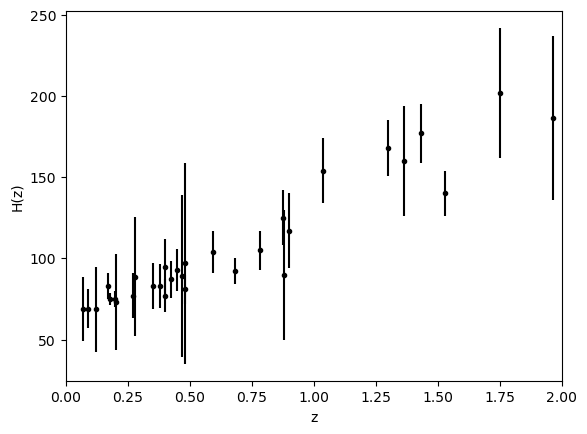

In [2]:
z = np.array([0.07,0.09,0.12,0.17,0.179,0.199,0.20,0.27,0.28,0.352,0.3802,0.4,0.4004,0.4247,0.4497,0.47,0.4783,0.48,0.593,0.68,0.781,0.875,0.88,0.90,1.037,1.3,1.363,1.43,1.53,1.75,1.965])
H = np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,87.1,92.8,89,80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
Herr = np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.2,12.9,50,9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])

plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
z0 = np.linspace(0, 2, 100)
#plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H(z)");

In [3]:
def H_calc(z,params):
    H0,omega_m0,omega_k,wx = params
    return H0*np.sqrt(omega_m0*(1+z)**3 +omega_k*(1+z)**2  + (1-omega_k-omega_m0)*(1+z)**(3*(1+wx)))

In [11]:
from scipy.optimize import minimize

def chi_sqr(params):
    return np.sum(((H_calc(z,params) - H)/Herr)**2)

result = minimize(chi_sqr,x0 = [73.70426984,  0.19435141,  0.29401065, -2],bounds=[(0,np.inf),(0,1),(0,1),(-2,0)])
print(result)
print("Optimal solution:", result.x)  # Optimized variables
print("Minimum value:", result.fun)   # Minimum value found

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 14.120423056313054
        x: [ 7.370e+01  1.944e-01  2.940e-01 -2.000e+00]
      nit: 1
      jac: [ 1.776e-06 -2.132e-06  5.329e-06  1.186e-01]
     nfev: 15
     njev: 3
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
Optimal solution: [73.70426984  0.19435143  0.29401066 -2.        ]
Minimum value: 14.120423056313054


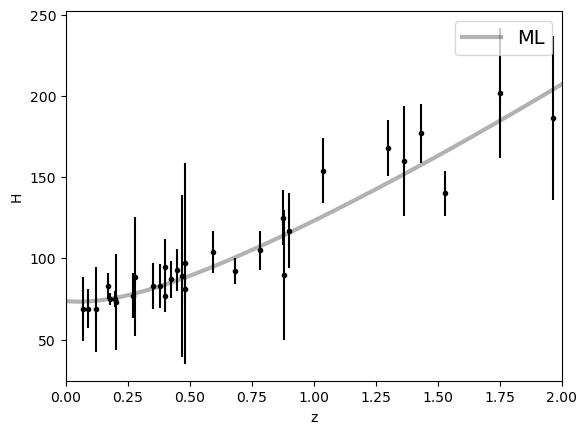

H0 =  73.70426983508378
Omega_m0 =  0.19435140538841894
Omega_k0 =  0.29401065225038525
wx =  -2.0


In [10]:
plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
plt.plot(z0, H_calc(z0,[result.x[0],result.x[1],result.x[2],result.x[3]]), "k", alpha=0.3, lw=3, label="ML")
#plt.plot(z0, np.dot(np.vander(z0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H")
plt.show()
print("H0 = ",result.x[0])
print("Omega_m0 = ",result.x[1])
print("Omega_k0 = ",result.x[2])
print("wx = ",result.x[3])

In [48]:
def log_prior(theta):
    H0,omega_m0,omega_k,wx = theta
    if 0<omega_m0<1 and 0<omega_k<1 and 50<H0<85 and -2<wx<0:
        return 0.0
    return -np.inf

In [49]:
def log_probability(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi_sqr(theta)/2

In [50]:
import emcee

pos = result.x + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z, H, Herr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████| 5000/5000 [00:16<00:00, 305.93it/s]


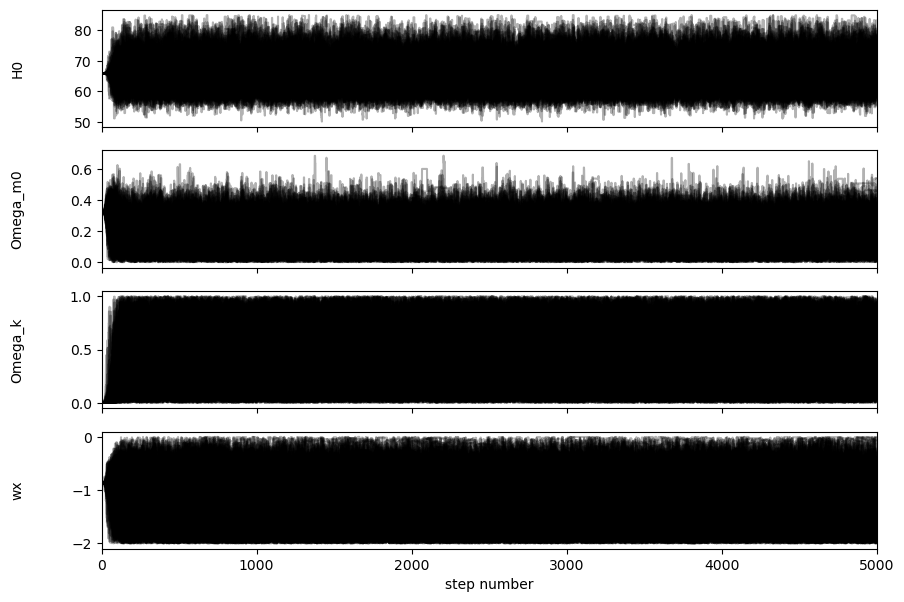

In [51]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0","Omega_m0","Omega_k","wx"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [52]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 80.15800121  74.39173741  87.0074863  101.46647407]

In [53]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(65200, 4)


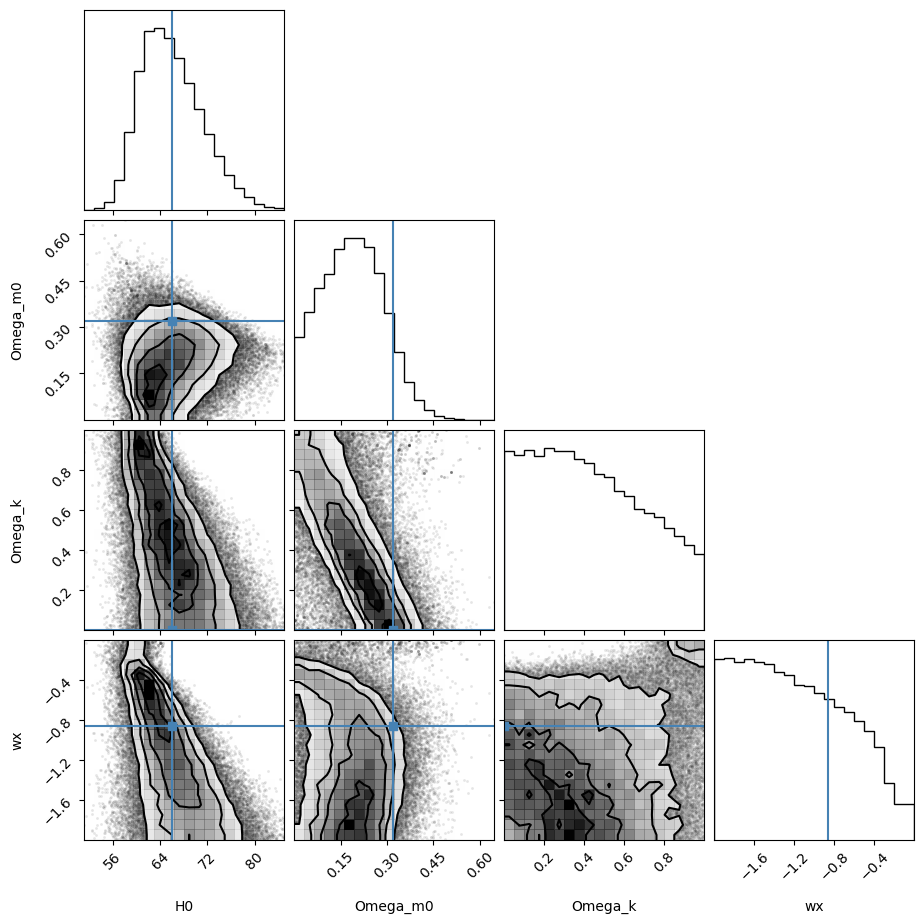

In [54]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.x[0], result.x[1],result.x[2],result.x[3]]
);

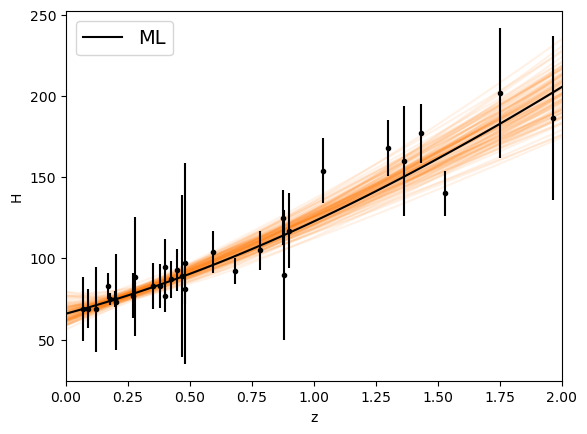

In [55]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(sample)
    plt.plot(z0, H_calc(z0,[sample[0],sample[1],sample[2],sample[3]]), "C1", alpha=0.1)
plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
plt.plot(z0, H_calc(z0,[result.x[0],result.x[1],result.x[2],result.x[3]]), "k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H");

In [56]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [57]:
from scipy import integrate

c = 2.99792458e+5 #km/s
rs_fid = 147.78 #Mpc

def Hinv(z,params):
    H0,omega_m0,omega_k,wx = params
    return 1/H_calc(z,params)

def Dm(z,params):
    return c*integrate.quad(Hinv,0,z,args=(params))[0]

In [58]:
def Dv(z,params):
    return np.cbrt((c*z*np.power(Dm(z,params),2))/H_calc(z,params))
def Dh(z,params):
    return c*Hinv(z,params)
def Da(z,params):
    return Dm(z,params)/(1+z)

In [59]:
def rs(z,params):
    H0,omega_m0,omega_k,wx = params
    omega_v0 = 0.0014
    h = H0/100
    omega_b = 0.02225/(h**2)
    num = np.exp(-72.3*(omega_v0*h**2+0.0006)**2)
    den = ((omega_b*h**2)**0.12807)*((omega_m0-omega_v0)*h**2)**0.25351
    return 55.154*num/den

In [60]:
import pandas as pd
r = pd.read_csv("/Users/User8/Downloads/BAO_data.csv")
z_values = r["z"]
A_obs = r["Values"]
A_err = r["sigma"]



print(r)

        z     Values    sigma
0   0.380  1512.3900   22.000
1   0.380    81.2087   27.000
2   0.510  1975.2200   32.000
3   0.510    90.9029    1.900
4   0.610  2306.6800    1.900
5   0.610    98.9647    2.100
6   0.122   539.0000    0.015
7   0.810    10.7500   25.000
8   1.520  3843.0000  170.000
9   2.340     8.8600    0.350
10  2.340    37.4100    0.300


In [61]:
C = np.array([
    [624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778, 0, 0, 0, 0, 0],
    [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056, 0, 0, 0, 0, 0],
    [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013, 0, 0, 0, 0, 0],
    [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334, 0, 0, 0, 0, 0],
    [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327, 0, 0, 0, 0, 0],
    [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0.1849, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 21609, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0841, -0.183396],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -0.183396, 3.4596]
])
Cinv = np.linalg.inv(C)
print(Cinv)


[[ 2.41657574e-03 -1.08425129e-02 -9.77915124e-04  6.54318580e-03
   9.58923119e-05 -1.10347720e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.08425129e-02  2.67032468e-01  4.97942781e-03 -1.33483795e-01
  -8.96901216e-04  2.03235036e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.77915124e-04  4.97942781e-03  2.13608860e-03 -1.29721787e-02
  -7.22812335e-04  5.55904513e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.54318580e-03 -1.33483795e-01 -1.29721787e-02  3.68207044e-01
   4.92437098e-03 -1.53528669e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.58923119e-05 -8.96901216e-04 -7.22812335e-04  4.92437098e-03
   1.17162779e-03 -8.10070309e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.10347720e-03  2.03235036e-02  5.55904513e-03 -1.53528669e-01
  -8.10070309e-03  

In [62]:
def ATheo(z,params):
    #print(z)
    A_theo = np.zeros(11)

    
    dm_ind = [0,2,4]
    h_ind = [3,1,5]
    dv_ind = [6,8]
    da_ind = [7]
    dhrs_ind = [9]
    dmrs_ind = [10]
    
    
    for i in dm_ind:
        A_theo[i] = Dm(z[i],params)*rs_fid/rs(z[i],params)
    for i in h_ind:   
        A_theo[i] = H_calc(z[i],params)*rs_fid/rs(z[i],params)
    for i in dv_ind:
        if i==6:
            A_theo[i] = Dv(z[i],params)*147.5/rs(z[i],params)
        else:
            A_theo[i] = Dv(z[i],params)*rs_fid/rs(z[i],params)
    A_theo[7] = Da(z[7],params)/rs(z[7],params)
    A_theo[9] = Dh(z[9],params) / rs(z[9],params)
    A_theo[10] = Dm(z[10],params)/rs(z[10],params)                         
    
    return A_theo

ATheo(z_values,[73.70426984,  0.19435141,  0.29401065, -2])

array([1387.91973659,   77.03887918, 1807.71374989,   83.54511516,
       2107.66708481,   89.18413365,  460.40493977,    9.91356097,
       3520.5298541 ,    7.87957835,   35.66586999])

In [63]:
def chi_sqr2(params):
    A = ATheo(z_values,params) - A_obs
    chi_sq = np.matmul(A.T,np.matmul(Cinv,A))
    
    return chi_sq

print(chi_sqr2([73.70426984,  0.19435141,  0.29401065, -2]))

100.01251659619372


In [64]:
def Chi_sqr(params):
    return (chi_sqr(params)+chi_sqr2(params))


result = minimize(Chi_sqr,x0 = [73.70426984,  0.19435141,  0.29401065, -2],bounds=[(0,np.inf),(0,1),(0,1),(-2,0)])
print(result)
print(result.x)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 19.572683666670898
        x: [ 6.597e+01  3.205e-01  0.000e+00 -8.649e-01]
      nit: 31
      jac: [ 3.553e-06  4.263e-06  1.019e+01  1.386e-05]
     nfev: 180
     njev: 36
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
[65.97227395  0.3205275   0.         -0.86488292]


In [65]:
def log_probability2(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - (Chi_sqr(theta))/2

In [66]:
import emcee

pos = result.x + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

z_tot = np.concatenate((z,z_values))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability2, args=(z_tot, H, Herr)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 5000/5000 [08:50<00:00,  9.42it/s]


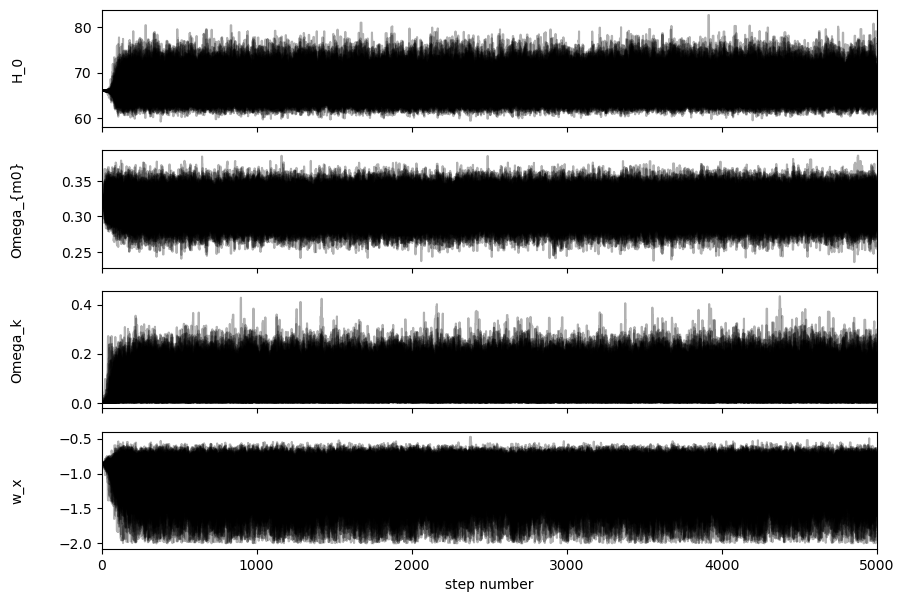

In [75]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H_0","Omega_{m0}","Omega_k","w_x"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [68]:
tau = sampler.get_autocorr_time()
print(tau)

[58.85707535 52.45756764 63.44489555 68.08698611]


In [69]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(65200, 4)


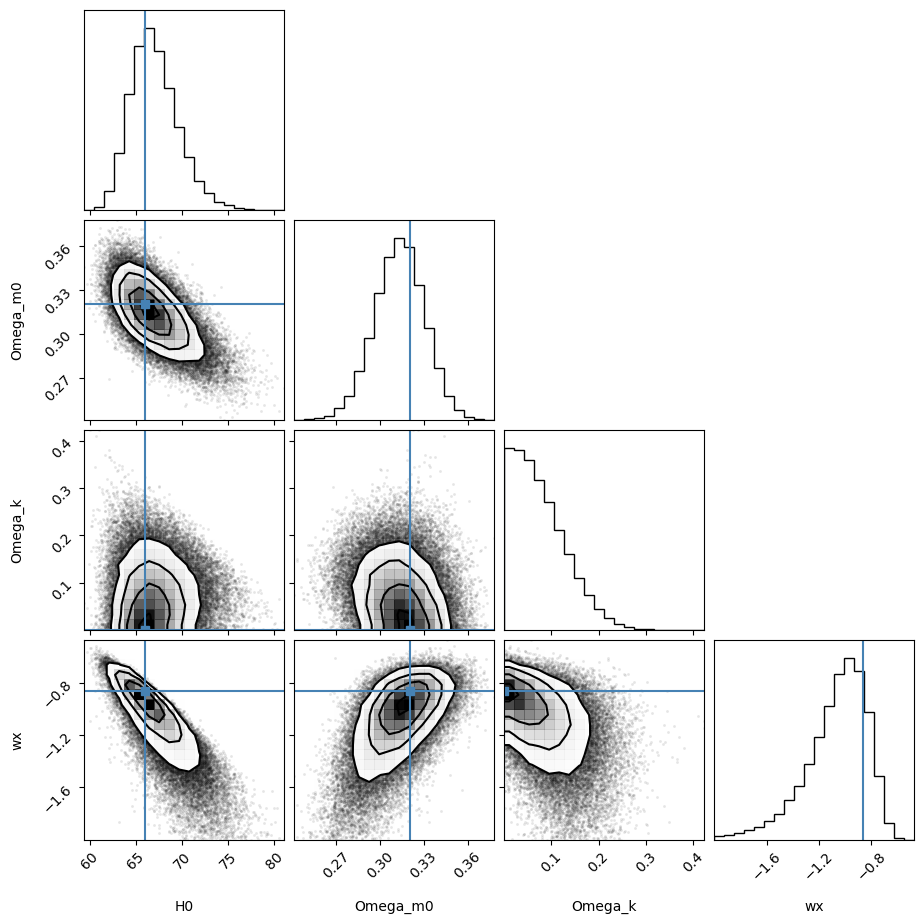

In [71]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.x[0], result.x[1],result.x[2],result.x[3]]
);

In [76]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [77]:
import pandas as pd
r = pd.read_csv("/Users/User8/Downloads/QSO - Sheet1.csv")
z_values2 = r["Z"]
t_obs = r["0"]
t_err = r["σg"]



print(r)

           Source       Z      0     σg       S       α Type
0      P 2351-006  0.4620  2.743  0.027   2.490    -0.1    Q
1          3C 279  0.5362  1.454  0.052  11.800     0.1    Q
2      P 0252-549  0.5390  1.049  0.077   1.940     0.1    Q
3       P 1136-13  0.5580  1.974  0.048   3.400    -0.3    Q
4       P 0403-13  0.5740  2.399  0.077   4.000     0.1    Q
..            ...     ...    ...    ...     ...     ...  ...
115    P 1032-199  2.1980  1.434  0.036   1.082     0.1  NaN
116    P 2314-409  2.4480  1.676  0.045   0.525  -0.3 Q  NaN
117  GC 1337 + 63  2.5584  1.598  0.323   0.600    -0.2  NaN
118    P 0329-255  2.6850  1.506  0.101   0.417  -0.1 Q  NaN
119  P 0136 + 176  2.7300  1.252  0.132   0.520    0 PQ  NaN

[120 rows x 7 columns]


In [78]:
lm = 11.03

def t_theo(z,params):
    results = []
    for value in z:
        # Perform operations using 'value' from the Series
        result = lm / Da(value, params)
        results.append(result)
    return results

In [79]:
def chi_sqr3(params):
    return np.sum(((t_theo(z_values2,params) - t_obs)/(0.1*t_obs + t_err))**2)
print(chi_sqr3([73.70426984,  0.19435141,  0.29401065, -2]))

3904.0830707254545


In [81]:
def Chi_sqr(params):
    return (chi_sqr(params)+chi_sqr2(params)+chi_sqr3(params))


result = minimize(Chi_sqr,x0 = [70,0.024,0.3,-1.2],bounds=[(0,np.inf),(0,1),(0,1),(-2,0)])
print(result)
print(result.x)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3923.9674638980614
        x: [ 6.606e+01  3.212e-01  0.000e+00 -8.669e-01]
      nit: 27
      jac: [-4.547e-05 -4.547e-04  9.857e+00  1.364e-04]
     nfev: 145
     njev: 29
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
[66.06392344  0.32115227  0.         -0.86689034]


In [82]:
def log_probability2(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - (Chi_sqr(theta))/2

In [83]:
import emcee

pos = result.x + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

z_tot = np.concatenate((z,z_values))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability2, args=(z_tot, H, Herr)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████| 5000/5000 [4:11:28<00:00,  3.02s/it]


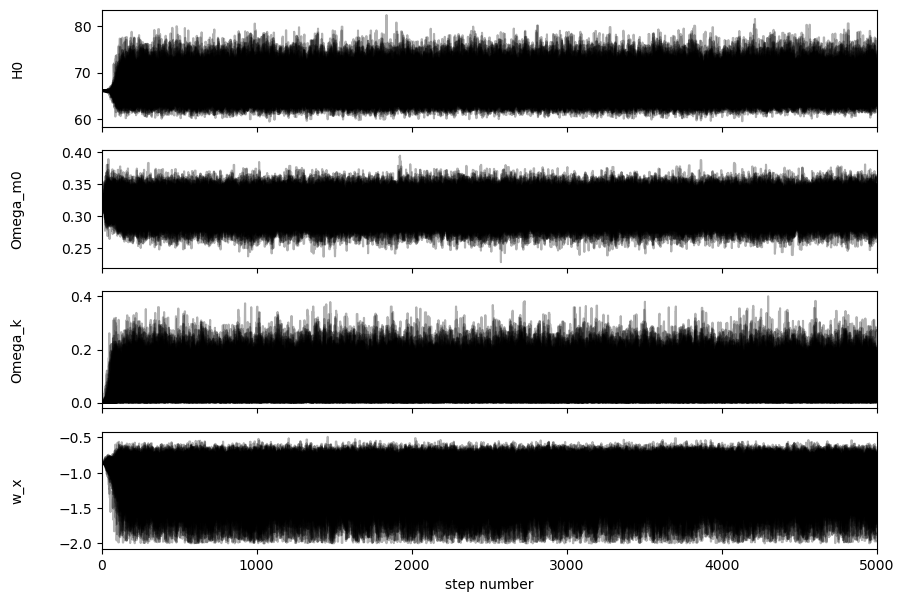

In [84]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0","Omega_m0","Omega_k","w_x"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [85]:
tau = sampler.get_autocorr_time()
print(tau)

[54.78297394 53.16788561 64.58528669 63.75121267]


In [86]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(65200, 4)


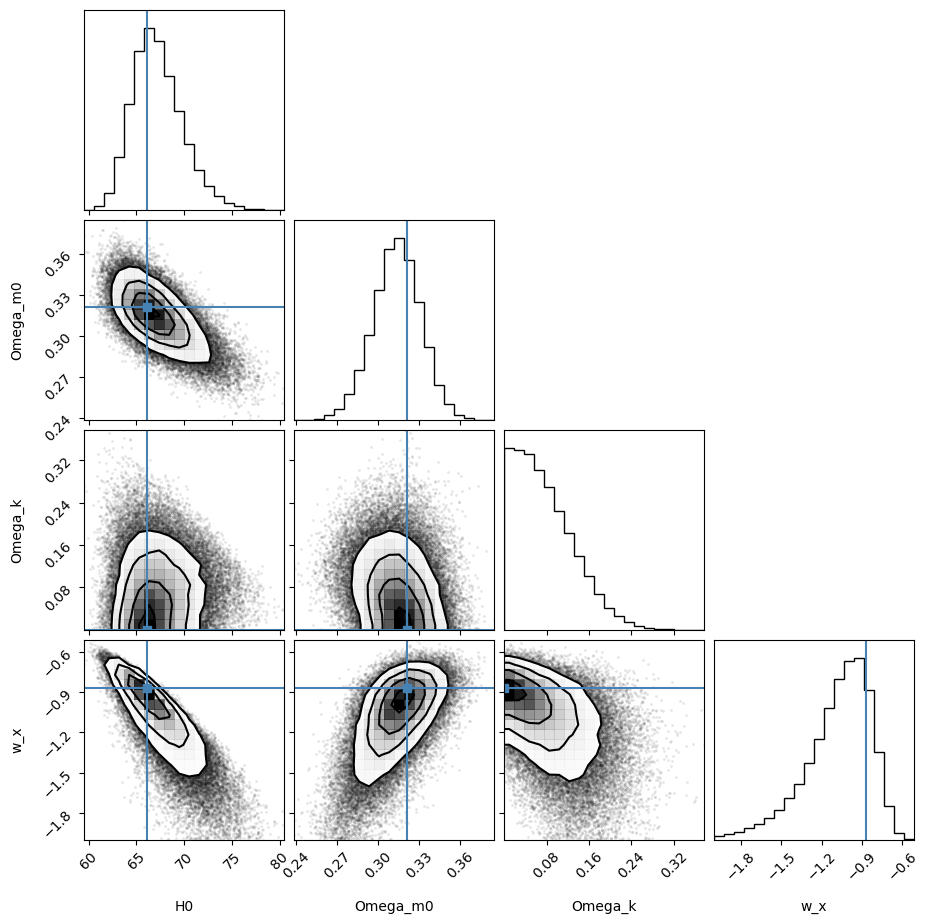

In [87]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.x[0], result.x[1],result.x[2],result.x[3]]
);

In [88]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>